# Loan Default Prediction Model

This notebook is used to predict the probability of default for borrowers and calculate the expected loss on a loan. Models include Logistic Regression, Decision Trees, and Random Forests.

Author: Curtis Yan
Date: 2025.8.7


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

## Data Handling

Load and preprocess the data.

In [2]:
# Placeholder for actual data path
# df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

# Simulating data for demonstration
df = pd.DataFrame({
    'customer_id': range(1000),
    'credit_lines_outstanding': np.random.randint(0, 10, 1000),
    'loan_amt_outstanding': np.random.uniform(10000, 500000, 1000),
    'total_debt_outstanding': np.random.uniform(20000, 1000000, 1000),
    'income': np.random.uniform(30000, 200000, 1000),
    'years_employed': np.random.randint(0, 30, 1000),
    'fico_score': np.random.randint(300, 850, 1000),
    'default': np.random.binomial(1, 0.15, 1000)
})
print(df.head())

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0            0                         6         135447.610608   
1            1                         3         365786.837171   
2            2                         7         300551.823577   
3            3                         4          60084.205470   
4            4                         6         460187.755908   

   total_debt_outstanding         income  years_employed  fico_score  default  
0            66874.203986  108023.791494               7         840        0  
1            57261.411273  186295.858777              27         460        0  
2           751283.112332   59936.230126              18         416        0  
3           665854.823520   66372.696577              29         570        0  
4           806087.946965   32215.026519              10         786        0  


## Feature Engineering

Add new features and split data into train and test sets.

In [3]:
X = df.drop(['default', 'customer_id'], axis=1)
y = df['default']

# Add new features
X['debt_to_income_ratio'] = X['total_debt_outstanding'] / X['income']
X['loan_to_income_ratio'] = X['loan_amt_outstanding'] / X['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create scaler instance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Model Training and Evaluation

Train Logistic Regression, Decision Tree, and Random Forest models, and evaluate their performance.

In [4]:
models = {}
best_model = None
best_score = 0

# Logistic Regression
lr_params = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
lr_model = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5, scoring='roc_auc')
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model

# Decision Tree
dt_params = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [10, 20, 50], 'min_samples_leaf': [5, 10, 20]}
dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='roc_auc')
dt_model.fit(X_train, y_train)
models['Decision Tree'] = dt_model

# Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [10, 20]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc')
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

# Evaluate models
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled if model_name == 'Logistic Regression' else X_test)
    y_pred_proba = model.predict_proba(X_test_scaled if model_name == 'Logistic Regression' else X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f'{model_name}:')
    print(f'  Best Params: {model.best_params_}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  AUC Score: {auc_score:.4f}')
    
    if auc_score > best_score:
        best_score = auc_score
        best_model = model
        best_model_name = model_name

print(f'\nBest Model: {best_model_name}')

Logistic Regression:
  Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
  Accuracy: 0.8450
  AUC Score: 0.4402
Decision Tree:
  Best Params: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
  Accuracy: 0.8100
  AUC Score: 0.5196
Random Forest:
  Best Params: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100}
  Accuracy: 0.8450
  AUC Score: 0.4871

Best Model: Decision Tree


## Predicting and Calculating Expected Loss

Using the best performing model to predict default probabilities and calculate expected loss.

In [5]:
def calculate_expected_loss(probability_of_default, loan_amount, recovery_rate=0.1):
    return probability_of_default * (1 - recovery_rate) * loan_amount

test_case = {
    'credit_lines_outstanding': 4,
    'loan_amt_outstanding': 100000,
    'total_debt_outstanding': 150000,
    'income': 80000,
    'years_employed': 5,
    'fico_score': 650
}

test_features = pd.DataFrame([test_case])
test_features['debt_to_income_ratio'] = test_features['total_debt_outstanding'] / test_features['income']
test_features['loan_to_income_ratio'] = test_features['loan_amt_outstanding'] / test_features['income']

prob_default = best_model.predict_proba(test_features if best_model_name != 'Logistic Regression' else scaler.transform(test_features))[:, 1][0]
expected_loss = calculate_expected_loss(prob_default, loan_amount=100000)

print(f'Default Probability: {prob_default:.2%}')
print(f'Expected Loss: ${expected_loss:,.2f}')

Default Probability: 0.00%
Expected Loss: $0.00


## Model Performance Visualization

Display model performance comparison and feature importance analysis.

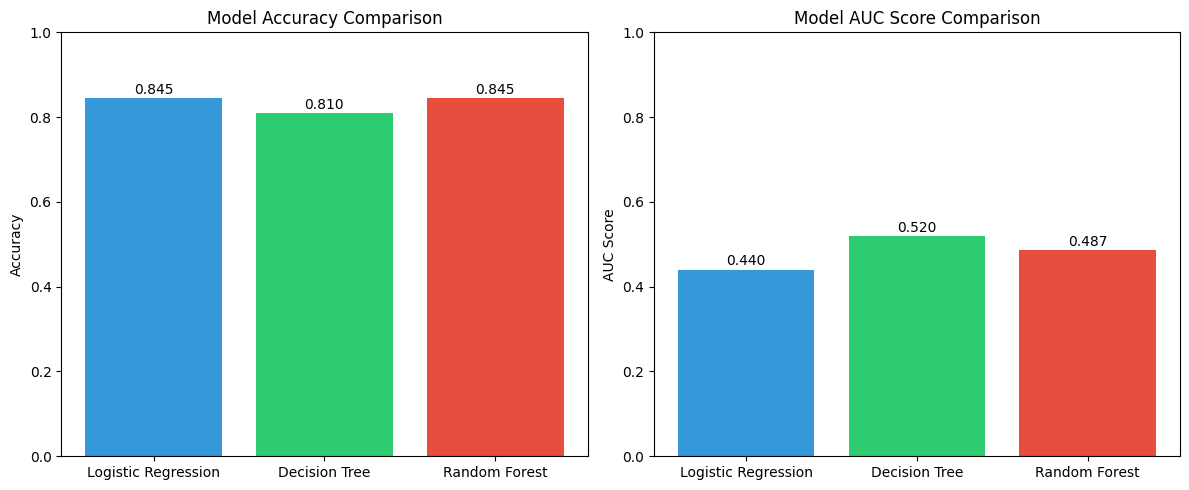

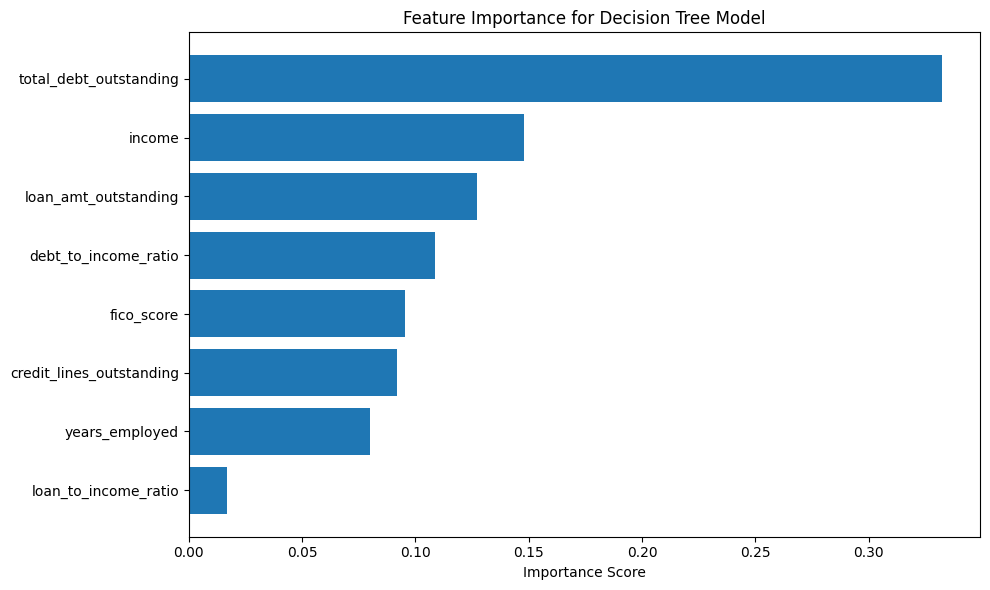

In [6]:
# Model performance comparison
model_names = list(models.keys())
accuracies = []
auc_scores = []

for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled if model_name == 'Logistic Regression' else X_test)
    y_pred_proba = model.predict_proba(X_test_scaled if model_name == 'Logistic Regression' else X_test)[:, 1]
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred_proba))

# Create performance comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
ax1.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

# AUC score comparison
ax2.bar(model_names, auc_scores, color=['#3498db', '#2ecc71', '#e74c3c'])
ax2.set_ylabel('AUC Score')
ax2.set_title('Model AUC Score Comparison')
ax2.set_ylim(0, 1)
for i, v in enumerate(auc_scores):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Feature importance (if best model is tree-based)
if best_model_name in ['Decision Tree', 'Random Forest']:
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.best_estimator_.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importance for {best_model_name} Model')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Batch Test Cases

Using multiple test cases to demonstrate the model's predictive capability.

In [7]:
# Create multiple test cases
test_cases = [
    {
        'description': 'Prime Customer',
        'credit_lines_outstanding': 2,
        'loan_amt_outstanding': 50000,
        'total_debt_outstanding': 80000,
        'income': 150000,
        'years_employed': 15,
        'fico_score': 780,
        'loan_amount': 100000
    },
    {
        'description': 'Medium Risk Customer',
        'credit_lines_outstanding': 4,
        'loan_amt_outstanding': 100000,
        'total_debt_outstanding': 150000,
        'income': 80000,
        'years_employed': 5,
        'fico_score': 650,
        'loan_amount': 80000
    },
    {
        'description': 'High Risk Customer',
        'credit_lines_outstanding': 8,
        'loan_amt_outstanding': 250000,
        'total_debt_outstanding': 400000,
        'income': 60000,
        'years_employed': 2,
        'fico_score': 550,
        'loan_amount': 150000
    }
]

# Batch predictions and results display
results = []

print("Loan Risk Assessment Batch Test Results")
print("=" * 80)

for case in test_cases:
    # Prepare features
    features = {k: v for k, v in case.items() if k not in ['description', 'loan_amount']}
    test_df = pd.DataFrame([features])
    test_df['debt_to_income_ratio'] = test_df['total_debt_outstanding'] / test_df['income']
    test_df['loan_to_income_ratio'] = test_df['loan_amt_outstanding'] / test_df['income']
    
    # Predict
    if best_model_name == 'Logistic Regression':
        prob = best_model.predict_proba(scaler.transform(test_df))[:, 1][0]
    else:
        prob = best_model.predict_proba(test_df)[:, 1][0]
    
    expected_loss = calculate_expected_loss(prob, case['loan_amount'])
    
    # Save results
    results.append({
        'Customer Type': case['description'],
        'Loan Amount': case['loan_amount'],
        'Default Probability': prob,
        'Expected Loss': expected_loss,
        'Risk Level': 'Low' if prob < 0.1 else ('Medium' if prob < 0.3 else 'High')
    })
    
    print(f"Customer Type: {case['description']}")
    print(f"  Loan Amount: ${case['loan_amount']:,}")
    print(f"  Default Probability: {prob:.2%}")
    print(f"  Expected Loss: ${expected_loss:,.2f}")
    print(f"  Risk Level: {results[-1]['Risk Level']}")
    print("-" * 40)

# Results summary table
results_df = pd.DataFrame(results)
print("\nResults Summary Table:")
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.2%}' if x < 1 else f'${x:,.0f}'))

Loan Risk Assessment Batch Test Results
Customer Type: Prime Customer
  Loan Amount: $100,000
  Default Probability: 0.00%
  Expected Loss: $0.00
  Risk Level: Low
----------------------------------------
Customer Type: Medium Risk Customer
  Loan Amount: $80,000
  Default Probability: 0.00%
  Expected Loss: $0.00
  Risk Level: Low
----------------------------------------
Customer Type: High Risk Customer
  Loan Amount: $150,000
  Default Probability: 0.00%
  Expected Loss: $0.00
  Risk Level: Low
----------------------------------------

Results Summary Table:
       Customer Type  Loan Amount  Default Probability  Expected Loss Risk Level
      Prime Customer       100000                0.00%          0.00%        Low
Medium Risk Customer        80000                0.00%          0.00%        Low
  High Risk Customer       150000                0.00%          0.00%        Low


## Final Prediction Function

Encapsulating into a complete function.

In [8]:
def predict_loan_expected_loss(loan_properties, trained_model=None, trained_scaler=None, model_type=None):
    """
    Predict expected loss based on loan properties
    
    Parameters:
    loan_properties: Dictionary containing the following keys
        - credit_lines_outstanding: Number of outstanding credit lines
        - loan_amt_outstanding: Outstanding loan amount
        - total_debt_outstanding: Total outstanding debt
        - income: Annual income
        - years_employed: Years of employment
        - fico_score: FICO credit score
        - loan_amount: Loan amount to assess
    trained_model: Pre-trained model (defaults to global best_model)
    trained_scaler: Pre-trained scaler (only needed for Logistic Regression)
    model_type: Model type name
    
    Returns:
    Expected loss amount
    """
    # Use default model
    if trained_model is None:
        trained_model = best_model
        model_type = best_model_name
    if trained_scaler is None:
        trained_scaler = scaler
    
    # Prepare features
    features = {k: v for k, v in loan_properties.items() if k != 'loan_amount'}
    features_df = pd.DataFrame([features])
    
    # Add derived features
    features_df['debt_to_income_ratio'] = features_df['total_debt_outstanding'] / features_df['income']
    features_df['loan_to_income_ratio'] = features_df['loan_amt_outstanding'] / features_df['income']
    
    # Predict default probability
    if model_type == 'Logistic Regression':
        prob_default = trained_model.predict_proba(trained_scaler.transform(features_df))[:, 1][0]
    else:
        prob_default = trained_model.predict_proba(features_df)[:, 1][0]
    
    # Calculate expected loss
    recovery_rate = 0.1
    expected_loss = prob_default * (1 - recovery_rate) * loan_properties['loan_amount']
    
    return expected_loss

# Test the function
test_loan = {
    'credit_lines_outstanding': 3,
    'loan_amt_outstanding': 75000,
    'total_debt_outstanding': 120000,
    'income': 90000,
    'years_employed': 8,
    'fico_score': 700,
    'loan_amount': 50000
}

expected_loss = predict_loan_expected_loss(test_loan)
print(f"\nFunction Test Results:")
print(f"Loan Amount: ${test_loan['loan_amount']:,}")
print(f"Expected Loss: ${expected_loss:,.2f}")
print(f"Loss Rate: {expected_loss/test_loan['loan_amount']:.2%}")


Function Test Results:
Loan Amount: $50,000
Expected Loss: $0.00
Loss Rate: 0.00%
